<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Set-Parameters" data-toc-modified-id="Set-Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set Parameters</a></span></li><li><span><a href="#Prepare-Random-Data" data-toc-modified-id="Prepare-Random-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare Random Data</a></span></li><li><span><a href="#Prepare-DataFrame-to-Record-Simulation-Results" data-toc-modified-id="Prepare-DataFrame-to-Record-Simulation-Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Prepare DataFrame to Record Simulation Results</a></span></li><li><span><a href="#Run-Simulation" data-toc-modified-id="Run-Simulation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Run Simulation</a></span></li><li><span><a href="#Fill-In-Derived-Data" data-toc-modified-id="Fill-In-Derived-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Fill-In Derived Data</a></span></li><li><span><a href="#Analyse-Results-of-this-Simulation-Run" data-toc-modified-id="Analyse-Results-of-this-Simulation-Run-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analyse Results of this Simulation Run</a></span></li><li><span><a href="#Run-Simulation-Study" data-toc-modified-id="Run-Simulation-Study-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Run Simulation Study</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Load Libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import simpy

# Set Parameters

In [2]:
INTERVAL_CUSTOMERS=0.5 # average time between events
PROCESSING_TIME=3  # average processing time in the bank
C=7
CUSTOMERS=10 # number of customers 


# Prepare Random Data

In [3]:
random.seed(42)

In [4]:
# Create a DataFrame with input parameters
cdata = pd.DataFrame()
cdata['arr'] = [ random.expovariate(1.0/INTERVAL_CUSTOMERS) for i in range(CUSTOMERS) ]
cdata['proc'] = [ random.expovariate(1.0/PROCESSING_TIME) for i in range(CUSTOMERS) ]

In [5]:
cdata.head()

,arr,proc
0,0.510030,0.740150
1,0.012664,2.111747
2,0.160812,0.080683
3,0.126293,0.665075
4,0.666796,3.148476


In [6]:
cdata.describe()

,arr,proc
count,10.000000,10.000000
mean,0.348945,1.751740
std,0.359852,1.587426
min,0.012664,0.019560
25%,0.065680,0.683844
50%,0.217418,1.429413
75%,0.550947,2.592567
max,1.113644,4.973214


In [7]:
def poissonPlot(data, title=None, max=None):
    μ = data.mean()
    n = data.count()
    
    if max is None:
        max = math.ceil(data.max()/10)*10
    
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(5)
    
    ax = fig.gca()
    ax.set_xlim(0, max)
    
    if title!=None:
        ax.set_title(title+" (n={:,})".format(n))
        
    data.hist(ax=ax, bins=max+1, density=True)

    x = [ i/10 for i in range(1, 10*max)]
    y = [ 1/μ*math.exp(-x/μ) for x in x]
    plt.plot(x, y, lw=3, color='red')
    ax.axvline(x=μ, color='red')
    plt.text(μ+0.2,0.9*y[0],'μ='+'%2.2f' % μ, color='red', fontsize=14)
    plt.grid(True)

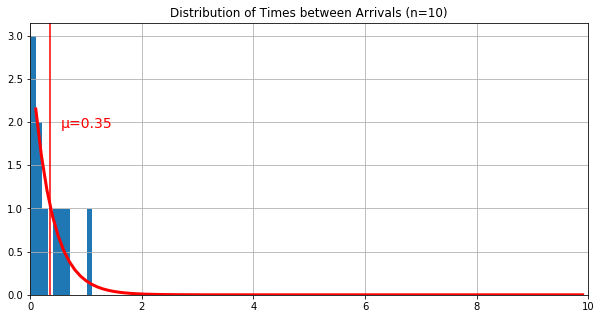

In [8]:
poissonPlot(cdata['arr'], title="Distribution of Times between Arrivals")

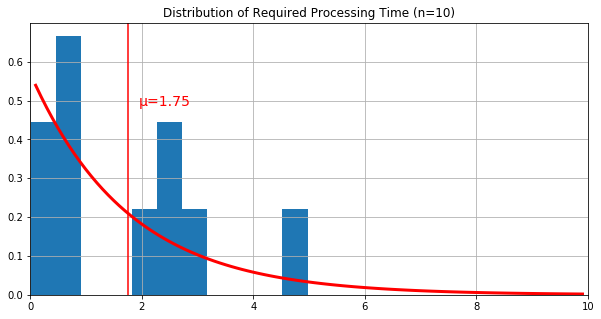

In [9]:
poissonPlot(cdata['proc'], title="Distribution of Required Processing Time")

# Prepare DataFrame to Record Simulation Results

In [10]:
# Prepare a DataFrame to record observations
sdata = pd.DataFrame()
sdata['arrived at'] = [None]*CUSTOMERS
sdata['proc started at'] = [None]*CUSTOMERS
sdata['proc finished at'] = [None]*CUSTOMERS 

In [11]:
sdata.head()

,arrived at,proc started at,proc finished at
0,None,None,None
1,None,None,None
2,None,None,None
3,None,None,None
4,None,None,None


# Run Simulation

Doc [simpy](https://simpy.readthedocs.io/en/latest/)

In [12]:
def source(env, n, counter):
    for i in range(n):
        t = cdata.at[i, 'arr']
        # wait until the next customer arrives...
        yield env.timeout(t)
        c = customer(env, i, counter)
        env.process(c)

In [13]:
def customer(env, i, counter):
    sdata.at[i, 'arrived at'] = env.now
    print(f"customer {i:d} arrives at  {env.now:6.2f}")
    
    req = counter.request()
        
    # Wait for the counter 
    yield req 

    print(f"serving customer {i:d} at  {env.now:6.2f}")
    sdata.at[i, 'proc started at'] = env.now
    
    yield env.timeout(cdata.at[i, 'proc'])
    
    sdata.at[i, 'proc finished at'] = env.now
    print(f"finished customer {i:d} at {env.now:6.2f}")
    
    counter.release(req)


In [14]:
len(cdata)

10

In [15]:
env = simpy.Environment()
counter = simpy.Resource(env, capacity=C)
env.process(source(env, CUSTOMERS, counter))
env.run()

customer 0 arrives at    0.51
serving customer 0 at    0.51
customer 1 arrives at    0.52
serving customer 1 at    0.52
customer 2 arrives at    0.68
serving customer 2 at    0.68
finished customer 2 at   0.76
customer 3 arrives at    0.81
serving customer 3 at    0.81
finished customer 0 at   1.25
finished customer 3 at   1.47
customer 4 arrives at    1.48
serving customer 4 at    1.48
customer 5 arrives at    2.04
serving customer 5 at    2.04
finished customer 1 at   2.63
customer 6 arrives at    3.15
serving customer 6 at    3.15
customer 7 arrives at    3.20
serving customer 7 at    3.20
customer 8 arrives at    3.47
serving customer 8 at    3.47
customer 9 arrives at    3.49
serving customer 9 at    3.49
finished customer 9 at   3.51
finished customer 6 at   3.90
finished customer 5 at   4.40
finished customer 4 at   4.63
finished customer 7 at   5.87
finished customer 8 at   8.45


In [16]:
sdata.head(10)

,arrived at,proc started at,proc finished at
0,0.51003,0.51003,1.25018
1,0.522695,0.522695,2.63444
2,0.683507,0.683507,0.76419
3,0.8098,0.8098,1.47487
4,1.4766,1.4766,4.62507
5,2.04118,2.04118,4.40317
6,3.15483,3.15483,3.90191
7,3.2003,3.2003,5.86973
8,3.47433,3.47433,8.44754
9,3.48945,3.48945,3.50901


# Fill-In Derived Data

In [17]:
sdata['wait time']=sdata['proc started at']-sdata['arrived at'] 
sdata['proc time']=sdata['proc finished at']-sdata['proc started at']
sdata['idle time']=sdata['proc started at']-sdata['proc finished at'].shift(1)
sdata.at[0, 'idle time']=sdata.at[0, 'proc started at']

In [18]:
sdata.head(10)

,arrived at,proc started at,proc finished at,wait time,proc time,idle time
0,0.51003,0.51003,1.25018,0,0.74015,0.51003
1,0.522695,0.522695,2.63444,0,2.11175,-0.727486
2,0.683507,0.683507,0.76419,0,0.0806832,-1.95093
3,0.8098,0.8098,1.47487,0,0.665075,0.0456099
4,1.4766,1.4766,4.62507,0,3.14848,0.00172133
5,2.04118,2.04118,4.40317,0,2.36199,-2.58389
6,3.15483,3.15483,3.90191,0,0.747079,-1.24834
7,3.2003,3.2003,5.86973,0,2.66943,-0.701603
8,3.47433,3.47433,8.44754,0,4.97321,-2.3954
9,3.48945,3.48945,3.50901,0,0.0195599,-4.95809


# Analyse Results of this Simulation Run

In [19]:
w = sdata['wait time']
print(f"Customers waited in average  {w.mean():5.2f}min.")
print(f"The minimum waiting time was {w.min():5.2f}min.")
print(f"the maximum waiting time was {w.max():5.2f}min.")

Customers waited in average   0.00min.
The minimum waiting time was  0.00min.
the maximum waiting time was  0.00min.


# Run Simulation Study

In [21]:
def ErlangC(N, A):
    L = (A**N / math.factorial(N)) * (N / (N - A))
    sum_ = 0
    for i in range(N):
        sum_ += (A**i) / math.factorial(i)
    return (L / (sum_ + L))

In [22]:
def MMC(IARR, PROC, N, C=1, log=False, plot=False):
    cd = pd.DataFrame()
    cd['iarr'] = [ random.expovariate(1.0/IARR) for i in range(N) ]
    cd['proc'] = [ random.expovariate(1.0/PROC) for i in range(N) ]
    # Prepare a DataFrame to record observations
    sd = pd.DataFrame()
    sd['arrived at'] = [None]*N
    sd['proc started at'] = [None]*N
    sd['proc finished at'] = [None]*N 
    
    env = simpy.Environment()
    counter = simpy.Resource(env, capacity=C)
    
    # initialise variables describing the queue
    maxql=0  # maximum length of queue
    qt=0     # "integral" of ql from 0 to lastT
    lastT=0 # last time qt was updated
    
    # initialise variables describing the server
    maxs=0   # max number of customers served at anyone time
    s=0      # current number of customers being served
    st=0     # "integral" of s from 0 to env.now
    
    def source(n):
        # generate the customers.
        for i in range(n):
            # wait until the next customer arrives...
            yield env.timeout(cd.at[i, 'iarr'])
            c = customer(i)
            env.process(c)
     
    def customer(i):
        sd.at[i, 'arrived at'] = env.now
        
        nonlocal qt, lastT, maxql, s, st, maxs
        
        # length of the queue before the customer enters

        ql = len(counter.queue) 
        if ql==maxql:
            maxql = ql+1
        qt += ql*(env.now-lastT)
        lastT=env.now

        req = counter.request()
        # Wait for the counter 
        
        yield req
        
        # length of the queue just before the customer leaves
        ql = len(counter.queue)+1 
        qt += ql*(env.now-lastT)
        lastT=env.now
        
        sd.at[i, 'proc started at'] = env.now
        # Wait while the clerk is dealing with you
        
        s += 1
        if s>maxs:
            maxs = s
            
        proc = cd.at[i, 'proc']
        yield env.timeout(proc)
        sd.at[i, 'proc finished at'] = env.now
        counter.release(req)
        
        s -= 1
        st += proc
        
            
    env.process(source(N))
    env.run()
    
    sd['wait time']=sd['proc started at']-sd['arrived at'] 
    sd['proc time']=sd['proc finished at']-sd['proc started at']
    sd['flow time']=sd['proc finished at']-sd['arrived at']
        
    sd['idle time']=sd['proc started at']-sd['proc finished at'].shift(1)
    sd.at[0, 'idle time']=sd.at[0, 'proc started at']
    
    sd['idep']=sd['proc finished at']-sd['proc finished at'].shift(1)
    sd.at[0, 'idep']=sd.at[0, 'proc finished at']
    
    w = sd['wait time']
    f = sd['flow time']
    
    if plot:
        poissonPlot(cd['iarr'], "Inter-Arrival Times")
        poissonPlot(cd['proc'], "Processing Times")
        poissonPlot(sd['wait time'], "Wait Times")
        poissonPlot(sd['flow time'], "Flow Times")
        poissonPlot(sd['idep'], "Inter-Departure Times")
        
    if log:
        μ_iarr = cd['iarr'].mean()
        μ_proc = cd['proc'].mean()
        
        a_theor = PROC/IARR
        

        ρ = st/(C*lastT)
        ρ_theor = PROC/(C*IARR)
        
        EQ = ρ_theor / (1-ρ_theor)*ErlangC(C, a_theor)
        EB = C*ρ_theor
        EN = EB+EQ
        EWQ = ErlangC(C, a_theor)/(C/PROC-1/IARR)
        # PROC*ρ_theor/(1-ρ_theor)
        
        Lq = qt/lastT
  
        print("   actual / expected")
        print(f"a= {μ_iarr:6.2f}   {IARR:6.2f}   (Inter Arrival Time)")
        print(f"p= {μ_proc:6.2f}   {PROC:6.2f}   (Processing Time)")
        print(f"ρ= {100*ρ:5.1f}%  {100*ρ_theor:6.1f}%   (System Utilisation)")
        print(f"L= {C*ρ+Lq:6.2f}   {C*ρ_theor+EQ:6.2f}   (inventory in the system)")
        print(f"Lq={Lq:6.2f}   {EQ:6.2f}   (inventory in the queue)")
        print(f"Ls={C*ρ:6.2f}   {C*ρ_theor:6.2f}   (inventory in service)")
        print(f"W= {f.mean():6.2f}   {EWQ+PROC:6.2f}   (Flow Time through the System")
        print(f"Wq={w.mean():6.2f}   {EWQ:6.2f}   (Wait Time)")
        print(f"Ws={μ_proc:6.2f}   {PROC:6.2f}   (Service Time)")
        print()
        
    return w.mean(), w.max(), qt/lastT, maxql, st/lastT

In [23]:
random.seed(41)
wavg, wmax, qavg, qmax, util =MMC(0.5, 3, 1000, C=7, log=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   0.51     0.50   (Inter Arrival Time)
p=   2.96     3.00   (Processing Time)
ρ=  81.2%    85.7%   (System Utilisation)
L=   7.08     9.68   (inventory in the system)
Lq=  1.40     3.68   (inventory in the queue)
Ls=  5.69     6.00   (inventory in service)
W=   3.68     4.84   (Flow Time through the System
Wq=  0.73     1.84   (Wait Time)
Ws=  2.96     3.00   (Service Time)

Max Wq=  9.38  
Max Lq= 14  


   actual / expected
a=   0.53     0.50   (Inter Arrival Time)
p=   2.93     3.00   (Processing Time)
ρ=  79.4%    85.7%   (System Utilisation)
L=   7.17     9.68   (inventory in the system)
Lq=  1.61     3.68   (inventory in the queue)
Ls=  5.56     6.00   (inventory in service)
W=   3.78     4.84   (Flow Time through the System
Wq=  0.85     1.84   (Wait Time)
Ws=  2.93     3.00   (Service Time)

Max Wq=  9.75  
Max Lq= 18  


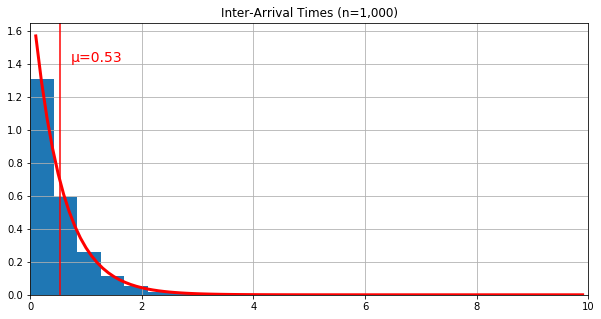

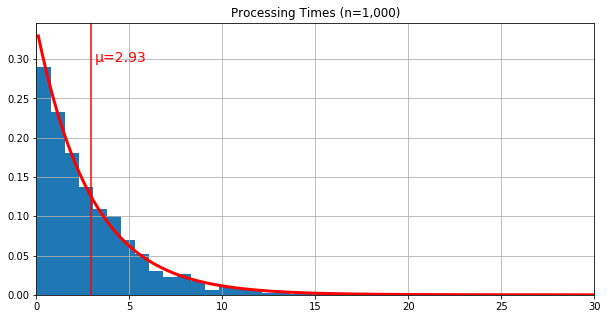

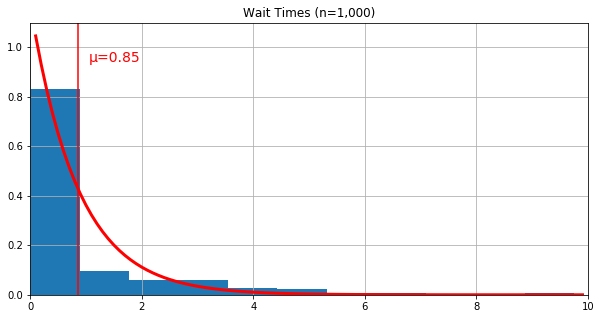

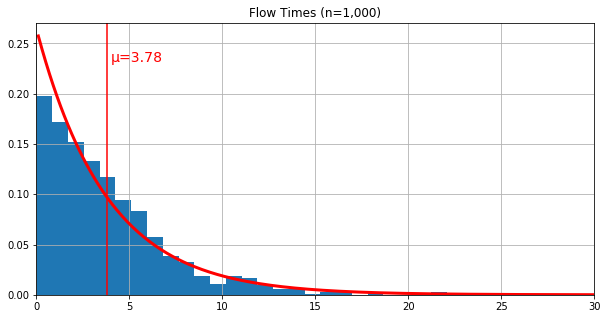

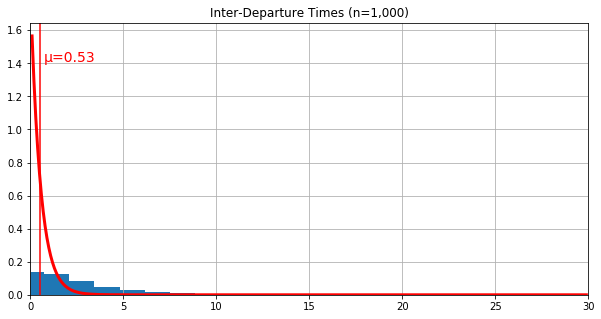

In [24]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MMC(0.5, 3, 1000, C=7, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   0.50     0.50   (Inter Arrival Time)
p=   3.02     3.00   (Processing Time)
ρ=  86.2%    85.7%   (System Utilisation)
L=   9.78     9.68   (inventory in the system)
Lq=  3.74     3.68   (inventory in the queue)
Ls=  6.04     6.00   (inventory in service)
W=   4.89     4.84   (Flow Time through the System
Wq=  1.87     1.84   (Wait Time)
Ws=  3.02     3.00   (Service Time)

Max Wq= 14.61  
Max Lq= 31  


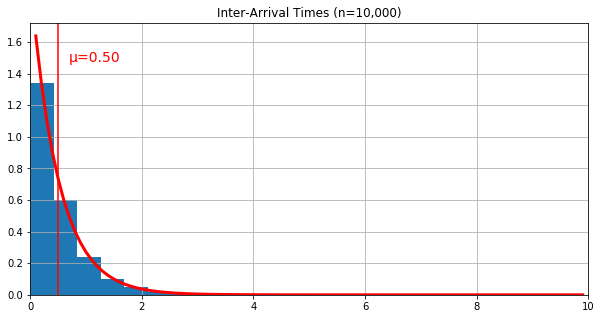

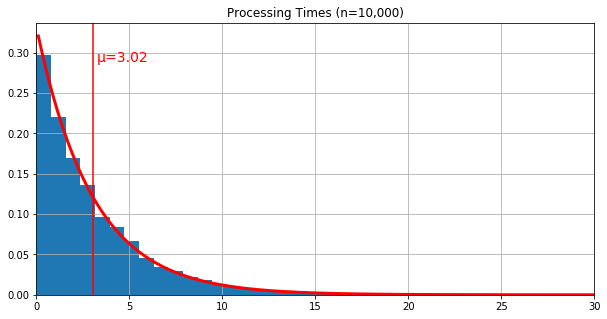

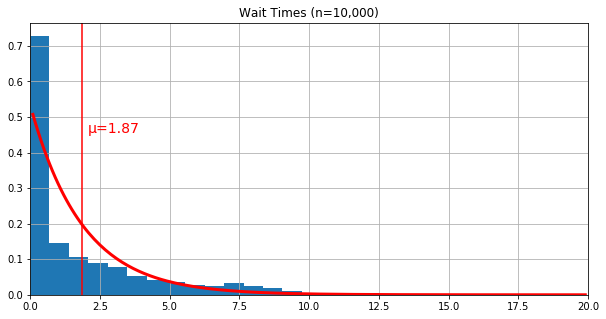

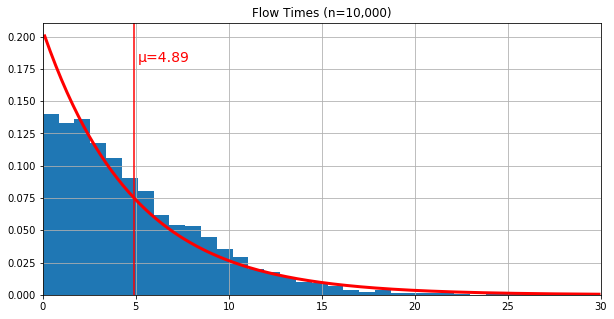

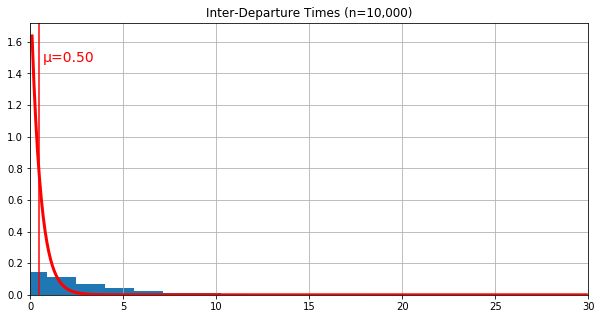

In [25]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MMC(0.5, 3, 10000, C=7, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

   actual / expected
a=   0.50     0.50   (Inter Arrival Time)
p=   3.01     3.00   (Processing Time)
ρ=  85.8%    85.7%   (System Utilisation)
L=   9.84     9.68   (inventory in the system)
Lq=  3.83     3.68   (inventory in the queue)
Ls=  6.01     6.00   (inventory in service)
W=   4.93     4.84   (Flow Time through the System
Wq=  1.92     1.84   (Wait Time)
Ws=  3.01     3.00   (Service Time)

Max Wq= 24.55  
Max Lq= 55  


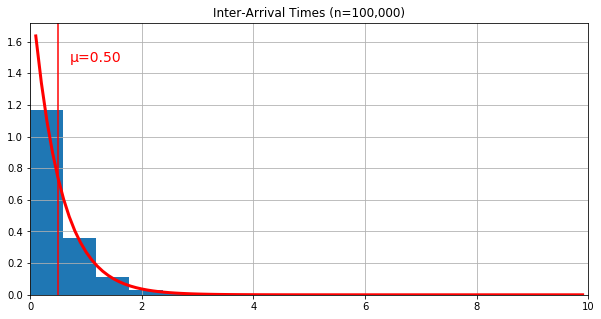

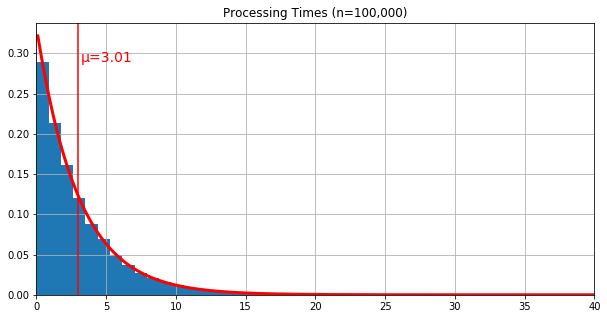

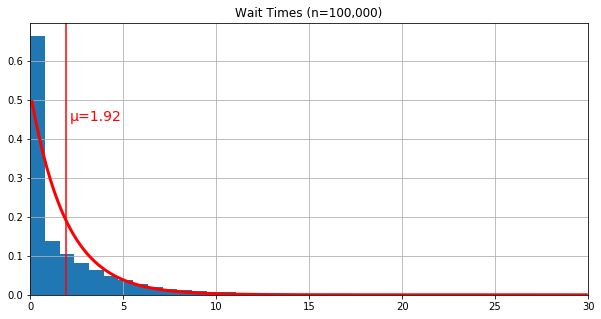

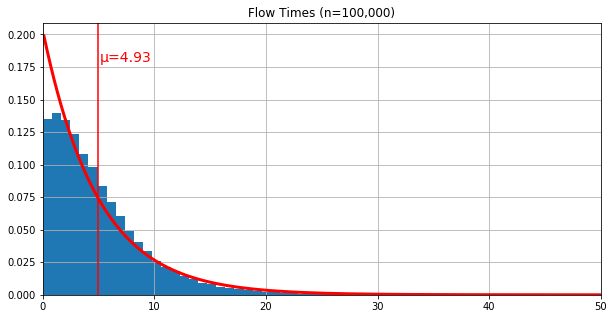

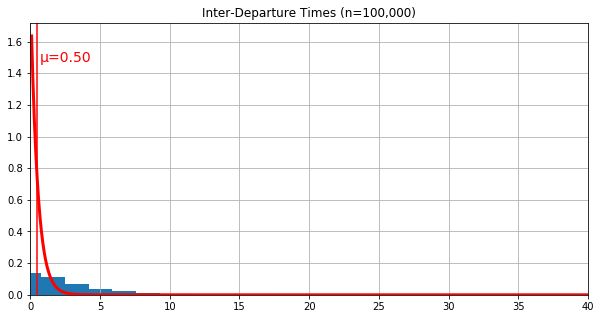

In [26]:
random.seed(42)
wavg, wmax, qavg, qmax, util =MMC(0.5, 3, 100000, C=7, log=True, plot=True)
print(f"Max Wq={wmax:6.2f}  ")
print(f"Max Lq={qmax:3d}  ")

# References

- [python math library]( https://docs.python.org/3/library/math.html)
- [matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html)
- [pandas](https://pandas.pydata.org/pandas-docs/stable/)
- [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html)
- [simpy](https://simpy.readthedocs.io/en/latest/contents.html) 
    [.pdf](https://readthedocs.org/projects/simpy/downloads/pdf/latest/)
    [The In-Depth Manual (2.2)](https://pythonhosted.org/SimPy/Manuals/Manual.html)